## Домашнее задание по свёрточным сетям

Сутью домашнего задания является последовательная реализация базовых операций, применяемых в свёрточных сетях с использованием операций над тензорами PyTorch, но без применения модулей torch.nn. Студенты должны самостоятельно реализовать как прямой и обратный проходы слоёв, так и классы нейронных сетей.

Правильность выполнения задания будет проверяться идентичностью прохождения процесса обучения в тех же архитектурах, выполненных с применением модулей и алгоритмов PyTorch.

### Задание 1

В первом задании требуется реализовать классы двухмерной свёртки **Conv**, линейного слоя **Fc**, алгоритм обучения нейронной сети **SGD**, функцию активации **ReLU**, **Softmax** и функцию эмпирического риска **CrossEntropyLoss**.

Свёрточные и полносвязные слои должны реализовывать операцию сдвига (*bias*, *b*). 
Сверить формулы прямого прохода можно в документации по [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) и [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

Далее, следует реализовать класс модели, который включает в себя реализованные выше компоненты. Требуется повторить параметры обучения и архитектуру, реализованную ниже с помощью torch.nn модулей. Критерием правильности решения будет совпадение значений эмпирического риска при обучении обеих реализаций сетей на одних и тех же данных, с теми же параметрами и с одинаковыми начальными инициализациями весов.

Данные для обучения состоят из 4 примеров вертикальных и горизонтальных линий. 


In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim
import torch.nn.functional as F
from tqdm import trange
import pandas as pd
import math
import copy

_ = torch.manual_seed(1)

In [2]:
def one_hot_encoding(y, num_classes):
    N = y.shape[0]
    Z = torch.zeros((N, num_classes))
    Z[torch.arange(N), y] = 1
    return Z

Train data shape [Batch, Channels, Height, Width] = torch.Size([4, 1, 5, 5])
Labels shape = torch.Size([4])
Mean and standard deviation before normalization = 49.90, 97.45
Mean and standard deviation after normalization = 0.00, 1.00
Train batch


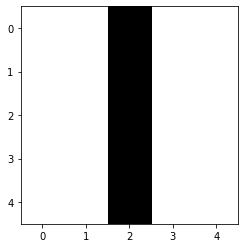

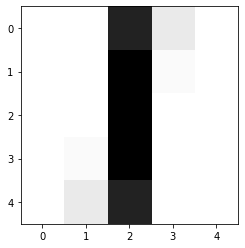

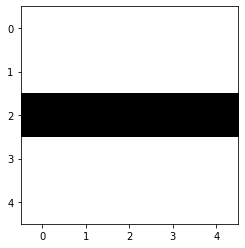

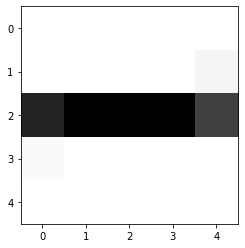

In [3]:
# Обучение будет вестись на следующих данных
def get_data():
    # Задача классификации вертикальных и горизонтальных линий
    # Данные
    vert1 = [[0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0]]

    vert2 = [[0, 0, 220, 40, 0],
             [0, 0, 250, 10, 0],
             [0, 0, 250, 0, 0],
             [0, 10, 250, 0, 0],
             [0, 40, 220, 0, 0]]

    hor1 = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [250, 250, 250, 250, 250],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]

    hor2 = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 20],
            [220, 250, 250, 250, 200],
            [10, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]

    data = [vert1, vert2, hor1, hor2]
    labels = [0, 0, 1, 1]
    
    train_x = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
    labels = torch.tensor(labels, dtype=torch.long)

    return train_x, labels

train_x, labels = get_data()
print(f'Train data shape [Batch, Channels, Height, Width] = {train_x.shape}')
print(f'Labels shape = {labels.shape}')


train_mean = torch.mean(train_x)
train_std = torch.std(train_x)
batch = (train_x - train_mean) / train_std

print(f'Mean and standard deviation before normalization = {train_mean.item():.2f}, {train_std.item():.2f}')
print(f'Mean and standard deviation after normalization = {torch.mean(batch).item():.2f}, {torch.std(batch).item():.2f}')

print('Train batch')
for img in batch:
    plt.imshow(img.squeeze(0), cmap='Greys')  # Цвета инвертированы. Чем темнее, тем значение пикселя больше
    plt.show() 

Реализуем эталонную модель **TorchGradientModel**, состоящую из следующих модулей:
- Сверточный слой с 4 фильтрами размера $5\times5$;
- Функция активации [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Линейный слой с 2 выходными нейронами для классов горизонтальной и вертикальной линий

Вопрос:
Каким ещё образом можно осуществить бинарную классификацию, не используя линейный слой, с 2 выходными нейронами?

**Ответ.** Можно подобрать размер свёрток так, чтобы на выходе получалось два канала, в каждом из которых будет тензор вероятности принадлежности к классам (в нашем случае детекция не нужна, поэтому достаточно на выходе получить 2 тензора размера 1 на 1, то есть output.shape = 2x1x1).

А ещё можно попробовать с одним нейроном: применять какую-нибудь сигмоиду и смотреть, если значение > 0.5, то отправляем в класс 1, иначе --- в класс 0.

In [4]:
class TorchGradientModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, padding=0, bias=True)
        self.act1 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 1 * 1, 2)
        # PyTorch автоматически применяет LogSoftmax при использовании CrossEntropyloss

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x

Дополнительная информация может быть найдена в комментариях к коду

In [5]:
# Данная сеть обучается за 3 эпохи, что удобно для процесса отладки.
learning_rate = 1
epochs = 10

# СТУДЕНТАМ:
# Сохраняйте историю эмпирического риска каждую эпоху в отдельном столбце loss_history 'loss_custom'
loss_history = pd.DataFrame(index=range(epochs), dtype=float)

torch_grad_model = TorchGradientModel()

# СТУДЕНТАМ:
# Используйте эти веса, чтобы инициализировать веса своей сети для точной воспроизводимости результатов
# torch_model_params[0] - тензор с весами фильтров W свёрточного слоя
# torch_model_params[1] - тензор с весами сдвигов b свёрточного слоя
# torch_model_params[2] - тензор с весами W линейного слоя
# torch_model_params[3] - тензор с весами сдвигов b линейного слоя
torch_model_params = []
temp_m = copy.deepcopy(torch_grad_model)
for param in temp_m.named_parameters():
    torch_model_params.append(param[1].clone().detach())

# СТУДЕНТАМ:
# При реализации своих слоёв не забывайте делить получившиеся градиенты по ошибкам на размер пакета 
# (для I-го слоя - это кол-во изображений),
# чтобы эмулировать поведение CrossEntropyLoss с параметром reduction='mean'
ce = nn.CrossEntropyLoss(reduction='mean')

# Для данного эксперимента используется самый простой алгоритм обучения без моментов.
optimizer = torch.optim.SGD(torch_grad_model.parameters(), lr=learning_rate, 
                            momentum=0, dampening=0, weight_decay=0, 
                            nesterov=False)

In [6]:
torch_grad_model.train()
t = trange(epochs)
loss_hist_pt = []
for e in t:
    predict_y = torch_grad_model(batch) # для обучения используем весь пакет
    
    # Можете выводить веса сети для прямого сравнения со своей реализацей
    print('Parameters')
    for param in torch_grad_model.named_parameters():
        print(param)
    print('==============================================================')

    loss = ce(predict_y, labels)
    loss_history.loc[e, 'loss_pt'] = loss.item()
    
    # Градиенты нужно обнулять в каждой эпохе
    optimizer.zero_grad()
    loss.backward()
    
    # Градиенты также можно выводить в текстовом виде для оценки хода обучения
#     print('Gradients')
#     for param in torch_grad_model.named_parameters():
#         print(param[0], param[1].grad)"
    
    optimizer.step()
    
    train_acc = torch.sum(torch.argmax(predict_y, axis=1) == labels).item()

    train_acc /= batch.shape[0]
    t.set_postfix(loss=loss.item(), accuracy=train_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Parameters
('conv1.weight', Parameter containing:
tensor([[[[ 0.1031, -0.0883, -0.0388,  0.0939, -0.1883],
          [ 0.1199, -0.0411,  0.1017,  0.0278, -0.0245],
          [ 0.0555,  0.0099,  0.0730, -0.0779, -0.0146],
          [-0.0180,  0.0290, -0.0008,  0.1748,  0.0622],
          [-0.0745, -0.1208, -0.0335, -0.0863, -0.0641]]],


        [[[ 0.0096,  0.1192,  0.1087, -0.1955,  0.1240],
          [ 0.0559,  0.1897,  0.1320, -0.1822, -0.1902],
          [-0.0965,  0.1756, -0.0333,  0.0856, -0.0929],
          [ 0.1962, -0.0846,  0.1500,  0.0024, -0.1054],
          [ 0.1028, -0.1062,  0.0588, -0.0578, -0.0219]]],


        [[[-0.1923, -0.0954,  0.1085, -0.0486,  0.1992],
          [ 0.1603, -0.0094, -0.1335,  0.1218,  0.0621],
          [-0.1293,  0.1299,  0.1214,  0.1774, -0.1121],
          [-0.0329, -0.0039,  0.0292, -0.1518, -0.1419],
          [ 0.1088, -0.0469,  0.0977,  0.0114,  0.0657]]],


        [[[ 0.0440,  0.0727,  0.0991, -0.1852,  0.1007],
          [-0.1406, -0.150

100%|██████████| 10/10 [00:00<00:00, 12.86it/s, accuracy=1, loss=0.00251]

Parameters
('conv1.weight', Parameter containing:
tensor([[[[ 0.0790, -0.1124, -0.4897,  0.0344, -0.2124],
          [ 0.0958, -0.0652, -0.3758, -0.0051, -0.0255],
          [ 0.5708,  0.5599,  0.1697,  0.4721,  0.4777],
          [-0.0305, -0.0040, -0.4783,  0.1507,  0.0381],
          [-0.0986, -0.1803, -0.4845, -0.1104, -0.0882]]],


        [[[ 0.0814,  0.1911, -0.1584, -0.1517,  0.1959],
          [ 0.1277,  0.2616, -0.1562, -0.1174, -0.1183],
          [-0.0246,  0.2475, -0.3215,  0.1575, -0.0211],
          [ 0.2681, -0.0198, -0.1382,  0.0742, -0.0335],
          [ 0.1747, -0.0624, -0.2083,  0.0141,  0.0499]]],


        [[[-0.1807, -0.0838,  0.3246, -0.0201,  0.2108],
          [ 0.1719,  0.0022,  0.0953,  0.1376,  0.0625],
          [-0.3763, -0.1337,  0.0751, -0.0862, -0.3480],
          [-0.0269,  0.0119,  0.2580, -0.1402, -0.1304],
          [ 0.1204, -0.0184,  0.3138,  0.0230,  0.0772]]],


        [[[ 0.0314,  0.0601, -0.1361, -0.2162,  0.0881],
          [-0.1532, -0.163

limit_output extension: Maximum message size of 10000 exceeded with 17568 characters

Ниже представлены заготовки (шаблоны) классов, колторые требуется реализовать. **Conv**, **Fc** и **ReLU** должны иметь методы **forward** и **backward** для прямого и обратного прохода по сети. При прямом проходе следует кэшировать данные, которые потребуются для вычисления градиента.

**Свёртки**

При прямом проходе нужно брать фильтры поочерёдно и проводить свёртку со входным тензором. Каждая операция свёртки даёт 2-мерную матрицу на выходе. Для получения итоговой карты признаков следует сконкатенировать эти матрицы, чтобы получить тензор рамерами [Размер батча, Количество каналов, Высота, Ширина]. Реализовывать можно как с помощью вложенных циклов, так и с применением векторизации. В данном задании важно не время работы, но точность вычислений.

В первом модуле заданий уже была показана реализация обратного прохода по линейному слою для подсчёта частных производных по эмпирическому риску, которые использовались для обновления весов слоя. Расчёт частных производных в свёрточных слоях идеологически тот же. Требуется посчитать частные производные по dX предыдущему входу слоя, dW по весам фильтров и db по сдвигам. Пусть dZ – это градиент ошибки к выходу текущего свёрточного слоя (передаётся от предыдущего слоя при обратном проходе сети), тогда

$dX += \sum_{h=0}^{n_H}\sum_{w=0}^{n_W} W_c\times dZ_{hw}$,

где $W_c$ – это фильтр, а $dZ_{hw}$ – скаляр, соответствующий градиенту эмпирического риска к выходу текущего свёрточного слоя $Z$ в $n$ строке и $w$ столбце. Так как при прямом проходе фильтр $W_c$ влияет на все значения канала с карты признаков, то мы умножаем один и тот же фильтр $W_c$ с разными $dZ$ в пределах канала $с$, суммируя результаты.
В numpy эта операция выглядела бы так

 dX[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
 
В PyTorch очерёдность каналов иная: [Batch, Channel, Height, Width].

Производная одного фильтра относительно эмпирического риска  считается по формуле

$dW_c+=\sum_{h=0}^{n_H}\sum_{w=0}^{n_W}x_{slice} \times dZ_{hw}$,

где $x_{slice}$ относится к отрезку из входного тензора, который был использован в прямом проходе, чтобы получить активацию $Z_{ij}$. Таким образом мы получим градиент фильтра $W$ относительно данного отрезка. Так как в рамках свёрточного слоя для разных отрезков мы использовали тот же фильтр $W$, то мы складываем эти градиенты, чтобы получить $dW$.

В numpy подобная операция реализуется так:

dW[:,:,:,c] += x_slice * dZ[i, h, w, c]

Производная по сдвигам считается как сумма всех градиентов выхода свёрточного слоя:

$db=\sum_{h=0}^{n_H}\sum_{w=0}^{n_W}dZ_{hw}$

В numpy реализовывалась бы так:

db[:,:,:,c] += dZ[i, h, w, c]


Для реализации выполнения обратного прохода градиента идентичным nn.CrossEntropyLoss(reduction='mean') образом, значения $dW$ и $db$ следует делить на размер пакета (batch).


**Замечание.** Хочется понять откуда взялись эти формулы... Вот [тут](https://towardsdatascience.com/backpropagation-in-a-convolutional-layer-24c8d64d8509) и [тут](https://medium.com/@pavisj/convolutions-and-backpropagations-46026a8f5d2c) выводят с примерами, но без учёта `stride` и `padding`.

Я сам пытался вывести часа 3 формулы в общем случае, но c градиентом по входу потрепел фиаско. Как же хорошо, что мне скинули в итоге вот эту [статью](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710).

In [7]:
from Task2Modules.CNN import Conv

Conv(1, 1, 1, init=torch_model_params)  # Проверка

**Замечание.** Дальше идут слои из первого задания, поэтому их просто скопируем оттуда ;)

In [8]:
from Task2Modules.OtherLayers import Fc, Softmax, LogSoftmax, Flatten
from Task2Modules.Optim import SGD
from Task2Modules.Activations import ReLU
from Task2Modules.Losses import CrossEntropyLoss

Fc(5, 5, torch_model_params[2:4])  # Проверка

Реализовать модель, идентичную **TorchGradientModel**. 

Если есть желание переиспользовать код из первого модуля заданий по линейным слоям, то можно реализовать модель, пользуясь предыдущими абстрактными классами и импортировать их здесь, переписав код для проверки результата.

In [9]:
from Task2Modules.CustomModels import CustomModel

In [10]:
def train_custom_model(X, y, epochs, num_classes):
    y = one_hot_encoding(labels, num_classes) # преобразуем число в эталоне в унитарный код.
    
    model = CustomModel(input_size=X.shape[-1], num_classes=num_classes, 
                        init=torch_model_params)
    cost = CrossEntropyLoss()
    
    params = model.get_params()

    optimizer = SGD(lr=learning_rate, params=params)      

    t = trange(epochs)
    
    for e in t:
        train_loss = 0
        train_acc = 0
        
        print('Parameters')
        for name, val in params.items():
            print(name, val)
        print('=============================================================')
  
        y_pred = model.forward(X)
        loss, deltaL = cost.get(y_pred, y)
        grads = model.backward(deltaL)
        # TODO: зачем такой функционал... параметры ведь по ссылке передаются
        params = optimizer.update_params(grads)
        model.set_params(params)

        train_loss += loss.item()
        train_acc = (
            torch.sum(torch.argmax(y_pred, axis=1) == labels).item() \
            / X.shape[0]
        )
        
        loss_history.loc[e, 'loss_custom'] = train_loss
        t.set_postfix(loss=train_loss, acc=train_acc)

In [11]:
train_custom_model(batch, labels, epochs, num_classes=2)

  0%|          | 0/10 [00:00<?, ?it/s]

Parameters
W1 tensor([[[[ 0.1031, -0.0883, -0.0388,  0.0939, -0.1883],
          [ 0.1199, -0.0411,  0.1017,  0.0278, -0.0245],
          [ 0.0555,  0.0099,  0.0730, -0.0779, -0.0146],
          [-0.0180,  0.0290, -0.0008,  0.1748,  0.0622],
          [-0.0745, -0.1208, -0.0335, -0.0863, -0.0641]]],


        [[[ 0.0096,  0.1192,  0.1087, -0.1955,  0.1240],
          [ 0.0559,  0.1897,  0.1320, -0.1822, -0.1902],
          [-0.0965,  0.1756, -0.0333,  0.0856, -0.0929],
          [ 0.1962, -0.0846,  0.1500,  0.0024, -0.1054],
          [ 0.1028, -0.1062,  0.0588, -0.0578, -0.0219]]],


        [[[-0.1923, -0.0954,  0.1085, -0.0486,  0.1992],
          [ 0.1603, -0.0094, -0.1335,  0.1218,  0.0621],
          [-0.1293,  0.1299,  0.1214,  0.1774, -0.1121],
          [-0.0329, -0.0039,  0.0292, -0.1518, -0.1419],
          [ 0.1088, -0.0469,  0.0977,  0.0114,  0.0657]]],


        [[[ 0.0440,  0.0727,  0.0991, -0.1852,  0.1007],
          [-0.1406, -0.1509,  0.0122, -0.0341,  0.1175],
     

 50%|█████     | 5/10 [00:00<00:00, 13.28it/s, acc=1, loss=2.98e-8] 

Parameters
W1 tensor([[[[ 0.0790, -0.1124, -0.4897,  0.0344, -0.2124],
          [ 0.0958, -0.0652, -0.3758, -0.0051, -0.0255],
          [ 0.5708,  0.5599,  0.1697,  0.4721,  0.4777],
          [-0.0305, -0.0040, -0.4783,  0.1507,  0.0381],
          [-0.0986, -0.1803, -0.4845, -0.1104, -0.0882]]],


        [[[ 0.0814,  0.1911, -0.1584, -0.1517,  0.1959],
          [ 0.1277,  0.2616, -0.1562, -0.1174, -0.1183],
          [-0.0246,  0.2475, -0.3215,  0.1575, -0.0211],
          [ 0.2681, -0.0198, -0.1382,  0.0742, -0.0335],
          [ 0.1747, -0.0624, -0.2083,  0.0141,  0.0499]]],


        [[[-0.1807, -0.0838,  0.3246, -0.0201,  0.2108],
          [ 0.1719,  0.0022,  0.0953,  0.1376,  0.0625],
          [-0.3763, -0.1337,  0.0751, -0.0862, -0.3480],
          [-0.0269,  0.0119,  0.2580, -0.1402, -0.1304],
          [ 0.1204, -0.0184,  0.3138,  0.0230,  0.0772]]],


        [[[ 0.0314,  0.0601, -0.1361, -0.2162,  0.0881],
          [-0.1532, -0.1635, -0.2369, -0.0513,  0.1170],
     

limit_output extension: Maximum message size of 10000 exceeded with 13307 characters

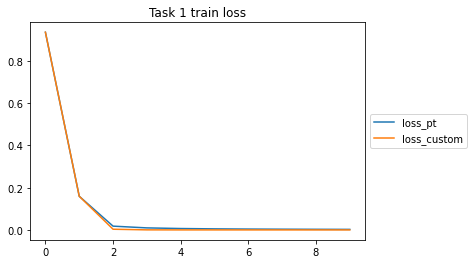

In [12]:
f = plt.figure()
plt.title('Task 1 train loss', color='black')
loss_history.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [13]:
# Эмпирический риск на всех эпохах должен совпадать с реализацией PyTorch
error = np.absolute((loss_history.iloc[:,0].values-loss_history.iloc[:,1].values)).sum()
if error < 1e-3:
    print('Задание 1 выполнено успешно')
else:
    print('Задание 1 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной')
print(f'Суммарная ошибка = {error:.4f}')
loss_history_task1 = loss_history

Задание 1 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной
Суммарная ошибка = 0.0481


### Задание 2

Требуется реализовать классы пакетной нормализации **BatchNorm2d** и слоя выборки усреднением **AvgPool**. Реализовать класс модели, идентичной эталонной TorchGradientModel2

Эталонная модель **TorchGradientModel2** состоит из:
- Сверточный слой с 4 фильтрами размера $3\times3$;
- Пакетная нормализация;
- Функция активации [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Выборки усреднением с ашгом 2 и размером окна 2
- Линейный слой с переменных количеством выходных нейронов

In [14]:
class TorchGradientModel2(nn.Module):
    def __init__(self, num_classes=2, input_size=5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=0, bias=True)
        self.bn1 = nn.BatchNorm2d(4)
        self.act1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * int((input_size - 2) / 2) * int((input_size - 2) / 2), num_classes)
        # PyTorch автоматически применяет LogSoftmax при использовании CrossEntropyloss

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [15]:
from torchsummary import summary

summary(TorchGradientModel2(), (1, 5, 5));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 4, 3, 3]             40
├─BatchNorm2d: 1-2                       [-1, 4, 3, 3]             8
├─ReLU: 1-3                              [-1, 4, 3, 3]             --
├─AvgPool2d: 1-4                         [-1, 4, 1, 1]             --
├─Flatten: 1-5                           [-1, 4]                   --
├─Linear: 1-6                            [-1, 2]                   10
Total params: 58
Trainable params: 58
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


In [16]:
learning_rate = 1
epochs = 10

# СТУДЕНТАМ:
# Сохраняйте историю эмпирического риска каждую эпоху в отдельном столбце 
# loss_history 'loss_custom'
loss_history = pd.DataFrame(index=range(epochs), dtype=float)

torch_grad_model = TorchGradientModel2()

# СТУДЕНТАМ:
# Используйте эти веса, чтобы инициализировать веса своей сети для точной 
# воспроизводимости результатов
torch_model_params = []
temp_m = copy.deepcopy(torch_grad_model)
for param in temp_m.named_parameters():
    if param[0] in ('conv1.weight', 'conv1.bias', 'fc1.weight', 'fc1.bias'):
#         print(param)
        torch_model_params.append(param[1].detach().clone())

# СТУДЕНТАМ:
# При реализации своих слоёв не забывайте делить получившиеся градиенты 
# по ошибкам на размер пакета (кол-во изображений для I-го слоя),
# чтобы эмулировать поведение CrossEntropyLoss с параметром reduction='mean'
ce = nn.CrossEntropyLoss(reduction='mean')

# Для эксперимента используется самый простой оптимизатор. 
# При желании можете поэкспериментировать с другими, которые реализовали 
# для 1-го задания
optimizer = torch.optim.SGD(torch_grad_model.parameters(), 
                            lr=learning_rate, momentum=0, dampening=0, 
                            weight_decay=0, nesterov=False)

torch_grad_model.train()
t = trange(epochs)
loss_hist_pt = []
for e in t:
    predict_y = torch_grad_model(batch) # для обучения используем весь пакет
    
#     Можете выводить веса сети для прямого сравнения со своей реализацей, 
    for param in torch_grad_model.named_parameters():
        print(param)

    loss = ce(predict_y, labels)
    loss_history.loc[e, 'loss_pt'] = loss.item()
    
    # Градиенты нужно обнулять в каждой эпохе
    optimizer.zero_grad()
    loss.backward()
    
    # Градиенты так же можно выводить в текстовом виде для оценки хода обучения
#     print('Gradients')
#     for param in torch_grad_model.named_parameters():
#         print(param[0], param[1].grad)
    
    optimizer.step()
    
    train_acc = torch.sum(torch.argmax(predict_y, axis=1) == labels).item()

    train_acc /= batch.shape[0]
    t.set_postfix(loss=loss.item(), accuracy=train_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

('conv1.weight', Parameter containing:
tensor([[[[-0.1802,  0.1193, -0.1283],
          [-0.1566,  0.0189,  0.2413],
          [-0.2345,  0.1565,  0.2141]]],


        [[[ 0.3261, -0.2333,  0.0807],
          [-0.2465,  0.2846, -0.1293],
          [ 0.2008,  0.0099, -0.0260]]],


        [[[-0.0106,  0.0567,  0.1571],
          [ 0.0535,  0.1017, -0.2998],
          [ 0.2428,  0.2906,  0.2755]]],


        [[[ 0.2464, -0.2405, -0.1236],
          [ 0.2939, -0.2539,  0.3024],
          [-0.2622, -0.2348,  0.1630]]]], requires_grad=True))
('conv1.bias', Parameter containing:
tensor([-0.2395, -0.0764,  0.2425,  0.2640], requires_grad=True))
('bn1.weight', Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True))
('bn1.bias', Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[ 0.4729, -0.1015, -0.3886,  0.4923],
        [-0.1065, -0.2057,  0.1219, -0.3497]], requires_grad=True))
('fc1.bias', Parameter containing:
tens

 10%|█         | 1/10 [00:00<00:01,  6.70it/s, accuracy=1, loss=0.323]  

('conv1.weight', Parameter containing:
tensor([[[[-0.0665,  0.3350,  0.0896],
          [-0.3069, -0.0362,  0.1838],
          [-0.3887,  0.1005,  0.1522]]],


        [[[ 0.3815, -0.1816,  0.1062],
          [-0.2137,  0.3139, -0.1289],
          [ 0.1512, -0.0462, -0.1123]]],


        [[[-0.0269, -0.1267,  0.1634],
          [ 0.1046, -0.0166, -0.2207],
          [ 0.3390,  0.2245,  0.4140]]],


        [[[ 0.3011, -0.2338,  0.0908],
          [ 0.0867, -0.5190,  0.2508],
          [-0.2213, -0.2370,  0.3719]]]], requires_grad=True))
('conv1.bias', Parameter containing:
tensor([-0.2395, -0.0764,  0.2425,  0.2640], requires_grad=True))
('bn1.weight', Parameter containing:
tensor([1.0277, 0.9901, 1.1033, 0.9530], requires_grad=True))
('bn1.bias', Parameter containing:
tensor([-0.0713, -0.0123,  0.0314, -0.0518], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[ 0.5207, -0.1965, -0.5910,  0.4365],
        [-0.1543, -0.1107,  0.3243, -0.2938]], requires_grad=True))
('f

100%|██████████| 10/10 [00:00<00:00, 31.81it/s, accuracy=1, loss=0.0248]

('fc1.bias', Parameter containing:
tensor([0.2529, 0.3891], requires_grad=True))
('conv1.weight', Parameter containing:
tensor([[[[-0.1358,  0.2931,  0.0492],
          [-0.2973,  0.0049,  0.2200],
          [-0.3856,  0.1374,  0.1861]]],


        [[[ 0.3894, -0.1938,  0.1111],
          [-0.2064,  0.2996, -0.1231],
          [ 0.1581, -0.0604, -0.1062]]],


        [[[ 0.0039, -0.1617,  0.0427],
          [ 0.1601, -0.0282, -0.3204],
          [ 0.4636,  0.2855,  0.3980]]],


        [[[ 0.2167, -0.2181,  0.1317],
          [ 0.0323, -0.4708,  0.3237],
          [-0.3050, -0.2261,  0.4113]]]], requires_grad=True))
('conv1.bias', Parameter containing:
tensor([-0.2395, -0.0764,  0.2425,  0.2640], requires_grad=True))
('bn1.weight', Parameter containing:
tensor([1.2051, 0.9897, 1.2831, 1.1060], requires_grad=True))
('bn1.bias', Parameter containing:
tensor([ 0.1162, -0.0158,  0.0232,  0.0332], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[ 0.7559, -0.1924, -0.7935, 

limit_output extension: Maximum message size of 10000 exceeded with 12001 characters

Найдём формулы для `backward()` при подаче на вход строчного вектора $\vec{x}\in \mathbb{R}^{N\times C\times H\times W}$. В [оригинальной статье](https://arxiv.org/pdf/1502.03167.pdf) на странице 4 есть все формулы для реализации backward pass. Но там случай, когда $\vec{x}\in \mathbb{R}^{1\times m}$. Сначала распишем, что мы вообще считаем в фазе тренировки:

### Forward
#### BatchNorm
$$
\widehat{x}_{ncij} = \frac{x_{ncij} - \mu_c}{\sqrt{\sigma^2_c + \varepsilon}},\\
\mu_c = \frac{1}{N\cdot H\cdot W}\sum\limits_{n, i, j=1}^{N, H, W} x_{ncij},\ \sigma^2_c = \frac{1}{N\cdot H\cdot W}\sum\limits_{n, i, j=1}^{N, H, W} \big(x_{ncij} - \mu_c\big)^2.\\
$$
#### Scaling
$$
\vec{x} \in \mathbb{R}^{N\times C\times H\times W},\ \gamma \in \mathbb{R}^{1\times C\times 1\times 1},
\beta \in \mathbb{R}^{1\times C\times 1\times 1}, \\
\text{Scaling}(x) = \gamma x + \beta \equiv y,\ \text{Scaling}(x) \in \mathbb{R}^{N\times C\times H\times W}
$$
где $\gamma$ и $\beta$ &mdash; обучаемые параметры слоя.

### Backward
Теперь уже займёмся градиентами:
#### BatchNorm
$$
\frac{\partial \widehat{x}_{ncij}}{\partial x_{nkmn}} = \delta_{ck}\delta_{im}\delta_{jn} \frac{1}{\sqrt{\sigma^2_c + \varepsilon}},
\\
\frac{\partial \mu_c}{\partial x_{nkij}} = \delta_{ck} \frac{1}{N\cdot H\cdot W},
\\
\frac{\partial \sigma^2_c}{\partial x_{nkij}} = \delta_{ck}\frac{2(x_{ncij} - \mu_c)}{N\cdot H\cdot W},
\\
\frac{\partial L}{\partial \sigma^2_c} = \sum_{n,i,j=1}^{N, H, W}\frac{\partial L}{\partial {\widehat{x}}_{ncij}}\cdot\bigg(-0.5(x_{ncij} - \mu_c)(\sigma^2_c+ \varepsilon)^{-3/2}\bigg),
\\
\frac{\partial L}{\partial \mu_c} = \sum\limits_{n, i, j=1}^{N, H, W} \frac{\partial L}{\partial \widehat{x}_{ncij}} \frac{-1}{\sqrt{\sigma^2_c + \varepsilon}} + \frac{\partial L}{\partial \sigma^2_c}\frac{\sum_{n, i, j=1}^{N, H, W} -2(x_{ncij} - \mu_c)}{N\cdot H\cdot W} = \sum\limits_{n, i, j=1}^{N, H, W} \frac{\partial L}{\partial \widehat{x}_{ncij}} \frac{-1}{\sqrt{\sigma^2_c + \varepsilon}}, 
\\
\frac{\partial L}{\partial x_{ncij}} = \frac{\partial L}{\partial \widehat{x}_{ncij}} \cdot \frac{1}{\sqrt{\sigma^2_c + \varepsilon}} + \frac{\partial L}{\partial \mu_c} \cdot \frac{1}{N\cdot H\cdot W} + \frac{\partial L}{\partial \sigma^2_c} \cdot \frac{2(x_{ncij} - \mu_c)}{N\cdot H\cdot W}.
% \\= \frac{1}{N \sqrt{\sigma^2 + \varepsilon}} \bigg(N \frac{\partial L}{\partial \widehat{x}_j} - \sum\limits_{i=1}^N \frac{\partial L}{\partial \widehat{x}_j} - \widehat{x}_i \sum\limits_{i=1}^N \frac{\partial L}{\partial \widehat{x}_j}\cdot \widehat{x}_j\bigg).
$$
#### Scaling
$$
\frac{\partial L}{\partial \widehat{x}_{ncij}} = \frac{\partial L}{\partial y_{ncij}} \gamma_c, \\
\frac{\partial L}{\partial \gamma_c} = \sum_{n, i, j = 1}^{N, H, W} \frac{\partial L}{\partial y_{ncij}} \widehat{x}_{ncij}, \\
\frac{\partial L}{\partial \beta_c} = \sum_{n, i, j = 1}^{N, H, W} \frac{\partial L}{\partial y_{ncij}}.
$$

**Замечание.** Также отметим, что в torch-е в `BatchNorm2d` используется смещённая оценка дисперсии, поэтому формулы подправлять не надо.

In [17]:
kek = torch.tensor(
    [[[[ 5.1526, -4.4138, -1.9386,  4.6937, -9.4144], 
       [ 5.9972, -2.0573,  5.0874,  1.3902, -1.2244], 
       [ 2.7736,  0.4933,  3.6523, -3.8970, -0.7291], 
       [-0.9003,  1.4494, -0.0399,  8.7417,  3.1119], 
       [-3.7241, -6.0396, -1.6762, -4.3134, -3.2045]]]]
)
mu = torch.mean(kek, dim=(0, 2, 3), keepdim=True)  # (1, C, 1, 1)
sigma2 = torch.mean((kek - mu) ** 2, dim=(0, 2, 3), keepdim=True)
sigma2_unbiased = sigma2 * (25 / 24)

torch.var(kek), torch.var(kek, unbiased=False), sigma2_unbiased, sigma2

(tensor(18.2483),
 tensor(17.5183),
 tensor([[[[18.2483]]]]),
 tensor([[[[17.5183]]]]))

In [18]:
(2.7248)**0.5 * 25/24

1.719475856830279

In [19]:
3.7962 * 100 / 99

3.8345454545454545

**Замечание.** Так как архитектура не продумана преподавателем, нет интерфейсов, а у меня это делать сейчас времени нет, модель не будет уметь переключаться между train и test. Но сам слой будет уметь!

In [20]:
from Task2Modules.OtherLayers import BatchNorm2d

BatchNorm2d(4, 0.)  # Проверка

Теперь разберёмся с average pooling. Если расписать на листочке для простых примеров формулы, то становится понятно, что `backward()` очень похож на `backward()` в свёрточном слое, только теперь нет параметров (то есть не нужно считать градиент по параметрам) и все значения фильтра одинаковые (то есть вращать ничего не надо). Таким образом, из преобразований остаётся только раздвижение строк и столбцов друг от друга на `self.s - 1` с помощью функции `delate()`.

In [21]:
from Task2Modules.CNN import AvgPool

AvgPool(2, 2)  # Проверка

In [22]:
from Task2Modules.CustomModels import CustomModel2

CustomModel2()  # Проверка

In [23]:
def train_custom_model2(X, y, epochs, num_classes):
    y = one_hot_encoding(labels, num_classes) # преобразуем число в эталоне в унитарный код.
    
    model = CustomModel2(input_size=X.shape[-1], num_classes=num_classes)
    cost = CrossEntropyLoss()
    
    optimizer = SGD(lr=learning_rate, params=model.get_params())      

    t = trange(epochs)
    
    for e in t:
        train_loss = 0
        train_acc = 0 
  
        y_pred = model.forward(X)
        loss, deltaL = cost.get(y_pred, y)
        grads = model.backward(deltaL)
        params = optimizer.update_params(grads)
        model.set_params(params)

        train_loss += loss.item()
        train_acc = torch.sum(
            torch.argmax(predict_y, axis=1) == labels
        ).item() / X.shape[0]
        
        loss_history.loc[e, 'loss_custom'] = train_loss
        t.set_postfix(loss=train_loss, acc=train_acc)

In [24]:
train_custom_model2(batch, labels, epochs, num_classes=2)

100%|██████████| 10/10 [00:00<00:00, 32.67it/s, acc=1, loss=0.0323]


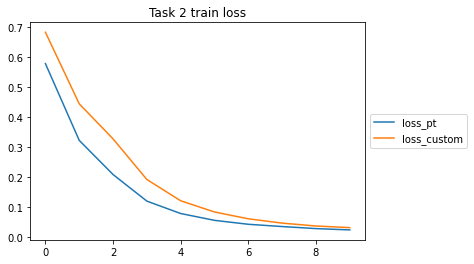

In [25]:
f = plt.figure()
plt.title('Task 2 train loss', color='black')
loss_history.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [26]:
# Эмпирический риск на всех эпохах должен совпадать с реализацией PyTorch
error = np.absolute((loss_history.iloc[:,0].values-loss_history.iloc[:,1].values)).sum()
if error < 1e-3:
    print('Задание 2 выполнено успешно')
else:
    print('Задание 2 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной')
print(f'Суммарная ошибка = {error:.4f}')
loss_history_task2 = loss_history

Задание 2 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной
Суммарная ошибка = 0.5330


### Задание 3

Обучить ранее реализованную сеть **CustomModel2** на реальных данных из выборки digits.

In [27]:
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 

# import torchvision  <-- Зачем???

(1797, 64)


<Figure size 432x288 with 0 Axes>

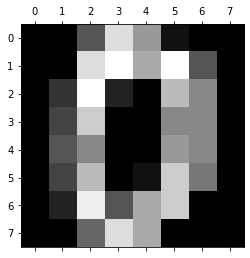

In [28]:
digits = load_digits()
print(digits.data.shape)

plt.gray()
plt.matshow(digits.images[0]);

In [29]:
def get_data_numbers():
    # Загружаем выборку digits
    data, labels = load_digits(n_class=10, return_X_y=True, as_frame=False)

    # ПРОВЕСТИ НЕОБХОДИМЫЕ ПРЕОБРАЗОВАНИЯ
    train_x, val_x, train_label, val_label = train_test_split(
        data.reshape(-1, 8, 8), labels, test_size=0.2, random_state=42
    )
    
    train_x = torch.tensor(train_x, dtype=torch.float).unsqueeze(1)
    train_label = torch.from_numpy(train_label)
    val_x = torch.tensor(val_x, dtype=torch.float).unsqueeze(1)
    val_label = torch.from_numpy(val_label)
    
    return train_x, train_label, val_x, val_label

In [30]:
train_x, train_label, val_x, val_label = get_data_numbers()
train_x.shape, train_x.dtype

(torch.Size([1437, 1, 8, 8]), torch.float32)

In [31]:
learning_rate = 1
epochs = 10
num_classes = 10

# СТУДЕНТАМ:
# Сохраняйте историю эмпирического риска каждую эпоху в отдельном столбце loss_history 'loss_custom'
loss_history = pd.DataFrame(index=range(epochs), dtype=float)

torch_grad_model = TorchGradientModel2(num_classes, input_size=8)

# СТУДЕНТАМ:
# Используйте эти веса, чтобы инициализировать веса своей сети для точной воспроизводимости результатов
torch_model_params = []
temp_m = copy.deepcopy(torch_grad_model)
for param in temp_m.named_parameters():
    if param[0] in ('conv1.weight', 'conv1.bias', 'fc1.weight', 'fc1.bias'):
        torch_model_params.append(param[1].detach().clone())

# СТУДЕНТАМ:
# При реализации своих слоёв не забывайте делить получившиеся градиенты по ошибкам 
# на размер пакета (кол-во изображений для I-го слоя),
# чтобы эмулировать поведение CrossEntropyLoss с параметром reduction='mean'
ce = nn.CrossEntropyLoss(reduction='mean')

# Для эксперимента используется самый простой оптимизатор. 
# При желании можете поэкспериментировать с другими, которые реализовали для 1-го задания
optimizer = torch.optim.SGD(torch_grad_model.parameters(), lr=learning_rate, 
                            momentum=0, dampening=0, weight_decay=0, 
                            nesterov=False)

torch_grad_model.train()
t = trange(epochs)
loss_hist_pt = []
for e in t:
    predict_y = torch_grad_model(train_x) # для обучения используем весь пакет
    
#     Можете выводить веса сети для прямого сравнения со своей реализацей, 
#     for param in torch_grad_model.named_parameters():
#         print(param)

    loss = ce(predict_y, train_label)
    loss_history.loc[e, 'loss_train_pt'] = loss.item()
    
    # Градиенты нужно обнулять в каждой эпохе
    optimizer.zero_grad()
    loss.backward()
    
    # Градиенты так же можно выводить в текстовом виде для оценки хода обучения
#     print('Gradients')
#     for param in torch_grad_model.named_parameters():
#         print(param[0], param[1].grad)
    
    optimizer.step()
    
    train_acc = torch.sum(
        torch.argmax(predict_y, axis=1) == train_label
    ).item() / train_x.shape[0]

    t.set_postfix(loss=loss.item(), accuracy=train_acc)

100%|██████████| 10/10 [00:00<00:00, 33.09it/s, accuracy=0.633, loss=1.36]


In [34]:
# TODO: и зачем мы создавали val?...
def train_model(epochs, learning_rate, loss_history, train_x, train_label, 
                val_x, val_labels):
    y_train = one_hot_encoding(train_label, num_classes)
    
    model = CustomModel2(input_size=train_x.shape[-1], 
                         num_classes=num_classes)
    cost = CrossEntropyLoss()
    optimizer = SGD(lr=learning_rate, params=model.get_params())      

    t = trange(epochs)
    
    for e in t:
        train_loss = 0
        train_acc = 0 
  
        y_pred = model.forward(train_x)
        loss, deltaL = cost.get(y_pred, y_train)
        grads = model.backward(deltaL)
        params = optimizer.update_params(grads)
        model.set_params(params)

        train_loss += loss.item()
        train_acc = torch.sum(
            torch.argmax(y_pred, axis=1) == train_label
        ).item() / train_x.shape[0]
        
        loss_history.loc[e, 'loss_custom'] = train_loss
        t.set_postfix(loss=train_loss, acc=train_acc)

In [35]:
# TODO: и зачем мы берём срезку в 10 элементов?...
# train_model(epochs, learning_rate, loss_history, train_x[0:10], 
#             train_label[0:10], val_x[0:10], val_label[0:10])

train_model(epochs, learning_rate, loss_history, train_x, train_label, 
            val_x, val_label)

100%|██████████| 10/10 [03:46<00:00, 22.66s/it, acc=0.659, loss=1.2] 


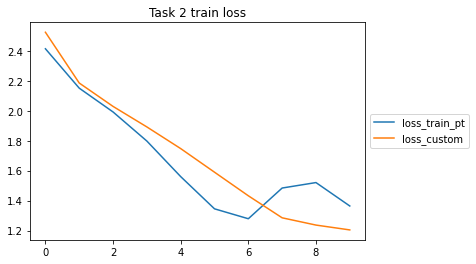

In [36]:
# loss_history = pd.DataFrame(index=range(epochs), dtype=float)

f = plt.figure()
plt.title('Task 2 train loss', color='black')
loss_history.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [39]:
loss_history

,loss_train_pt,loss_custom
0,2.413056,2.523335
1,2.150275,2.184558
2,1.991477,2.028513
3,1.797316,1.891569
4,1.560147,1.747051
5,1.345209,1.589581
6,1.279094,1.432263
7,1.483956,1.285262
8,1.520408,1.236814
9,1.364133,1.204502


In [41]:
# Эмпирический риск на всех эпохах должен совпадать с реализацией PyTorch
error = np.absolute(
    loss_history[['loss_custom']].to_numpy() -\
    loss_history[['loss_train_pt']].to_numpy()
).sum()
if error < 1e-3:
    print('Задание 3 выполнено успешно')
else:
    print('Задание 3 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной')
print(f'Суммарная ошибка = {error:.4f}')
loss_history_task2 = loss_history

Задание 3 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной
Суммарная ошибка = 1.5022


### Необязательное задание
Создать свою архитектуру свёрточной сети и обучиться на полной выборке digits, получив высокое качество классификации. Сравнить скорость и финальное качество обучения при применении разных алгоритмов обучения (SGD с моментом, Adam), регуляризации весов.

In [ ]:
# Если время в конце курса останется, сделаю, конечно